<a href="https://colab.research.google.com/github/animatedPentagon/ExperimentalDCGANs/blob/main/Hyperparameter_Optimized_Color_DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1s3uAhNvBFFUBhrwM62Wzn67tCU4MHOY6'})
download.GetContentFile('data.zip')
!unzip data.zip > /dev/null # Dont show any output

In [ ]:
latent_dim = 100
height = 64
width = 64
channels = 3

In [ ]:
from tensorflow import keras
from keras import layers
from IPython import display

In [ ]:
generator_input = keras.Input(shape = (latent_dim))

x = layers.Dense(64 * 16 * 16)(generator_input)
x = layers.BatchNormalization(momentum=0.5)(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,64))(x)

x = layers.Conv2D(128, 5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(64, 5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation = 'tanh', padding = 'same')(x)
x = layers.Reshape((64, 64, 3))(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       204928    
                                                             

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


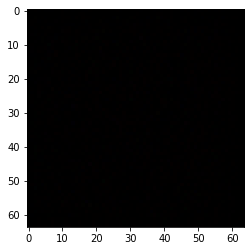

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])

In [ ]:
discriminator_input = layers.Input(shape = (height, width, channels))
x = layers.Conv2D(64, 3)(discriminator_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(32, 4, strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, 4, strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1)(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 62, 62, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 62, 62, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        32800     
                                                                 
 batch_normalization_7 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                           

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00016805]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001, clipvalue = 1.0, decay = 1e-8)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001, clipvalue = 1.0, decay = 1e-8)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import os

checkpoint_dir = "/content/drive/MyDrive/MyDCGAN"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
import os
import random
import numpy as np
import cv2
from skimage.transform import resize
from skimage.io import imread

num_samples = 45000
from skimage.transform import rescale
list_file = os.listdir('data')
# random.shuffle(list_file)
list_file = list_file[0: num_samples]

data_train_gan = np.array([resize(imread(os.path.join('data',file_name)), (64, 64)) for file_name in list_file])

In [ ]:
x_train = data_train_gan
iterations = 5000
BATCH_SIZE = 128
num_examples_to_generate = 8
seed = tf.random.normal([num_examples_to_generate, latent_dim])
start = 0

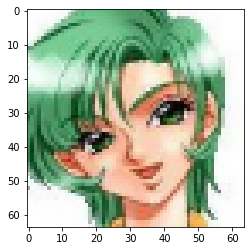

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data_train_gan[0])

In [ ]:
@tf.function
def train_step(images, toPrint = False):
    noise = tf.random.normal([BATCH_SIZE,latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      if(toPrint):
        print("Adversarial Loss:", gen_loss)
      disc_loss = discriminator_loss(real_output, fake_output)
      if(toPrint):
        print("Discriminator Loss:", disc_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, step, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')


  plt.savefig('image_at_iteration_{:04d}.png'.format(step))
  plt.show()


In [ ]:
from tqdm import tqdm_notebook

for step in tqdm_notebook(range(iterations)):
  stop = start + BATCH_SIZE
  real_images = x_train[start: stop]
  if (step + 1) % 10 == 0:
    train_step(real_images, True)
  else:
    train_step(real_images, False)
  start += BATCH_SIZE
  if start > len(x_train) - BATCH_SIZE:
    start = 0
 
  if (step + 1) % 10 == 0:
    # Produce images for the GIF as you go
    
    generate_and_save_images(generator,
                             step + 1,
                             seed)

    
  if (step + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
import glob

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vwsriiaf
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vwsriiaf
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=162411 sha256=16918aa1571f59f18a85ba3d348b15a4ed4ce14aa3eaa93e24a4ec37bb3bb1f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-les761c5/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import imageio

anim_file = 'batchsize128_60k_DifferentGen.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)